import thư viện và khai báo biến

In [1]:
import cv2
import numpy as np 
import math
import glob
from matplotlib import pyplot as plt
money_template = []
money_value = []

load các hình ảnh mẫu và giá trị vào biến

In [2]:
files = glob.glob("template\\*.png")
print(files)
for item in files:
    img = cv2.imread(item, 0)
    money_template.append (img)
    val = item.split("\\")[-1]
    val = val.split(".")[0]
    money_value.append(val)

['template\\1000   .png', 'template\\1000  .png', 'template\\1000 .png', 'template\\1000.png', 'template\\10000    .png', 'template\\10000  .png', 'template\\10000 .png', 'template\\10000.png', 'template\\100000   .png', 'template\\100000  .png', 'template\\100000 .png', 'template\\100000.png', 'template\\2000   .png', 'template\\2000  .png', 'template\\2000 .png', 'template\\2000.png', 'template\\20000  .png', 'template\\20000 .png', 'template\\20000.png', 'template\\500    .png', 'template\\500   .png', 'template\\500 .png', 'template\\500.png', 'template\\5000   .png', 'template\\5000  .png', 'template\\5000 .png', 'template\\5000.png', 'template\\50000   .png', 'template\\50000  .png', 'template\\50000 .png', 'template\\50000.png', 'template\\500000   .png', 'template\\500000  .png', 'template\\500000 .png', 'template\\500000.png']


xem giá trị của các biến mẫu

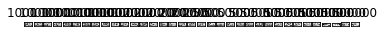

In [3]:
for i in range(len(money_template)):
    plt.subplot(1,len(money_template),i+1),plt.imshow(money_template[i],'gray')
    plt.title(money_value[i])
    plt.xticks([]),plt.yticks([])
plt.show()

Tải ảnh cần kiểm tra vào dưới dạng ảnh xám

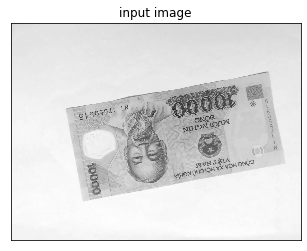

In [4]:
img = cv2.imread("image\\abc.jpg", 0)
plt.subplot(1,1,1),plt.imshow(img,'gray')
plt.title("input image")
plt.xticks([]),plt.yticks([])
plt.show()

bước 1: làm mờ ảnh bằng bộ lọc trung bình

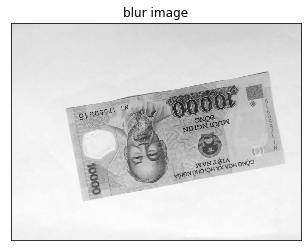

In [5]:
img_blur = cv2.blur(img, (5,5))
plt.subplot(1,1 , 1),plt.imshow(img_blur,'gray')
plt.title("blur image")
plt.xticks([]),plt.yticks([])
plt.show()
 #cv2.imwrite("out.png",img_blur )

bước 2: tìm cạnh (canny)

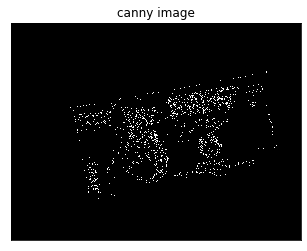

In [6]:
img_canny = cv2.Canny(img_blur,30, 40)
plt.subplot(1,1 , 1),plt.imshow(img_canny,'gray')
plt.title("canny image")
plt.xticks([]),plt.yticks([])
plt.show()
# cv2.imwrite("out.png",img_canny )

bước 3: threshold ostu

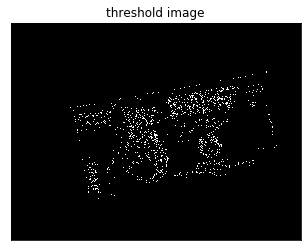

In [7]:
_, img_threshold = cv2.threshold(img_canny, 0, 255, cv2.THRESH_OTSU)
plt.subplot(1,1 , 1),plt.imshow(img_threshold,'gray')
plt.title("threshold image")
plt.xticks([]),plt.yticks([])
plt.show()
# cv2.imwrite("out.png",img_threshold )

bước 4: close hình ảnh với kernel (30,30)

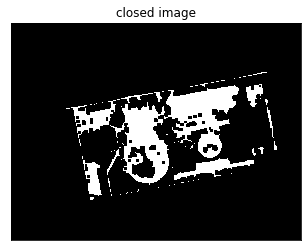

In [8]:
kernel = np.ones((30,30),np.uint8)
img_closed = cv2.morphologyEx(img_threshold, cv2.MORPH_CLOSE, kernel)
plt.subplot(1,1 , 1),plt.imshow(img_closed,'gray')
plt.title("closed image")
plt.xticks([]),plt.yticks([])
plt.show()
#cv2.imwrite("out.png",img_closed )

bước 5 tìm contours có kích thước lớn nhất là đồng tiền

In [9]:
_, contours, _ = cv2.findContours(img_closed,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

cnt = None
s_max_large = 0
for item in contours:
    s = cv2.contourArea(item)
    if(s > s_max_large):
        s_max_large = s
        cnt = item

bước 6: tìm hình chữ nhật nhỏ nhất bound lấy đồng tiền

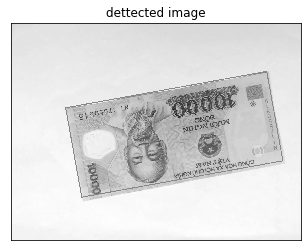

In [10]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
imgcp = img.copy()
im = cv2.drawContours(imgcp,[box],0,(127),10)
plt.subplot(1,1 , 1),plt.imshow(im,'gray')
plt.title("dettected image")
plt.xticks([]),plt.yticks([])
plt.show()
#cv2.imwrite("out.png",imgcp )

thực hiện tìm góc lệch và xoay ảnh lại cho đồng tiền nằm ngang

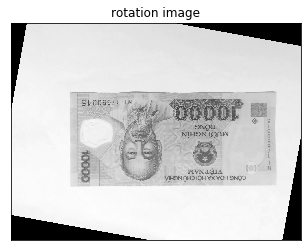

(2305.1650390625, 1022.7579345703125)


In [11]:
#xác định tâm xoay
M = cv2.moments(cnt)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
box = cv2.boxPoints(rect)
box = np.int0(box)
angle = rect[2]
RM = cv2.getRotationMatrix2D((cx,cy),angle,1)
# tính độ dài chiều cao (dist1) và chiều ngang(dist2). nếu chiều dọc > chiều ngang đồng tiền nằm dọc khi đó cần cộng thêm 90 độ xoay
dist1 = int(math.sqrt((box[1][0]  - box[0][0])**2 + (box[1][1]  - box[0][1])**2))
dist2 = int(math.sqrt((box[3][0]  - box[0][0])**2 + (box[3][1]  - box[0][1])**2))

# tìm tỉ lể đồng tiền mẫu và đồng tiền cần kiểm tra
if(dist1 > dist2):
    angle += 90
rows, cols = img.shape
# thực hiện xoay ảnh
RM = cv2.getRotationMatrix2D((cx,cy),angle,1)
img_rotated = cv2.warpAffine(img,RM,(cols,rows))
plt.subplot(1,1 , 1),plt.imshow(img_rotated,'gray')
plt.title("rotation image")
plt.xticks([]),plt.yticks([])
plt.show()
cv2.imwrite("img_rotated.png",img_rotated )

bước 7: thực hiện lại từ bươc 1 -> bước 5 để tim đồng tiền với bức ảnh đồng tiền nằm ngang

In [12]:
img_blur2 = cv2.blur(img_rotated, (5,5))
img_canny2 = cv2.Canny(img_blur2,30, 40)
_, img_threshold2 = cv2.threshold(img_canny2, 0, 255, cv2.THRESH_OTSU)
kernel2 = np.ones((30,30),np.uint8)
img_closed2 = cv2.morphologyEx(img_threshold2, cv2.MORPH_CLOSE, kernel2)
_, contours2, _ = cv2.findContours(img_closed2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

cnt2 = None
s_max_large2 = 0
for item in contours2:
    s = cv2.contourArea(item)
    if(s > s_max_large2):
        s_max_large2 = s
        cnt2 = item

bước 8: tìm hình chữ nhật bound contours lớn nhất và cắt hình ảnh với hình chữ nhật này

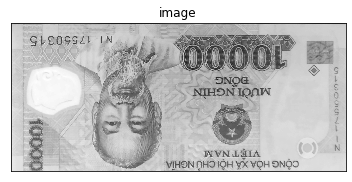

In [13]:
x,y,w,h = cv2.boundingRect(cnt2)
img_money = img_rotated[y:y+h, x:x+w]
plt.subplot(1,1 , 1),plt.imshow(img_money,'gray')
plt.title("image")
plt.xticks([]),plt.yticks([])
plt.show()
#cv2.imwrite("img_money.png",img_money )

bước 9: thực hiện so khớp( bằng phép trừ ảnh) với từng ảnh mẫu. nếu ảnh nào khớp nhất thì đồng tiền hiện tại có giá trị cùng với ảnh mẫu đó

In [14]:
val = ""
# đặt 1 giá trị đếm pixel vô cùng lớn(lớn hơn diện tích của hình ảnh đồng tiền)
min_count = 500*500 
# thực hiện làm mờ ảnh kiểm tra
img_det_blur = cv2.blur(img_money, (5,5))
for i , im in enumerate(money_template):
    # lấy kích thước của ảnh mẫu
    h,w = im.shape
    # thực hiện resize kích thước ảnh kiểm tra về cùng với ảnh mẫu để có thể trừ
    im_rz = cv2.resize(img_det_blur, (w,h))
    # làm mờ ảnh mẫu
    img_ref_blur = cv2.blur(im, (5,5))
    # cân bằng sáng ảnh mẫu và ảnh kiểm tra để tránh ánh sáng quá sáng hoặc quá tối
    eq_ref = cv2.equalizeHist(img_ref_blur)
    eq_def = cv2.equalizeHist(im_rz)
    # thực hiện trừ ảnh
    sub_img = cv2.subtract(eq_ref, eq_def)
    # phân ngưỡng và thực hiện đếm điểm không khớp (điểm sáng là điểm không khớp)
    _, img_threshold = cv2.threshold(sub_img, 0, 255, cv2.THRESH_OTSU)
    count = cv2.countNonZero(img_threshold)
    # giá trị này càng nhỏ thì độ khớp càng lớn
    if(count  < min_count):
        min_count = count
        val = money_value[i]
    #cv2.imwrite("out_jupyter1\\" + "lan1 - " + money_value[i] + ".png", sub_img)


bước 10: đồng tiền có thể nằm ngược nên xoay 180 độ và thực hiện so khớp lại 1 lần. nếu giá trị khớp nào tốt hơn thì lấy

In [15]:
# xoay ảnh 180 độ
rows, cols = img_det_blur.shape
M = cv2.getRotationMatrix2D((int(cols/2),int(rows/2)),180,1)
img_det_blur = cv2.warpAffine(img_det_blur,M,(cols,rows))
 #thực hiện so khớp lại lần 2
for i , im in enumerate(money_template):
    h,w = im.shape
    im_rz = cv2.resize(img_det_blur, (w,h))
    img_ref_blur = cv2.blur(im, (5,5))

    eq_ref = cv2.equalizeHist(img_ref_blur)
    eq_def = cv2.equalizeHist(im_rz)
    sub_img = cv2.subtract(eq_ref, eq_def)
    _, img_threshold = cv2.threshold(sub_img, 0, 255, cv2.THRESH_OTSU)
    count = cv2.countNonZero(img_threshold)
    if(count  < min_count):
        min_count = count
        val = money_value[i]
    #cv2.imwrite("out_jupyter2//" + "lan2 - " + money_value[i] + ".png", sub_img)

giá trị đồng tiền được lưu trong biến val khi quá trình kết thúc

In [16]:
print(val)

10000
